# CIC Current System Network Graph

# Graph overview 
               
Modeling as a weighted directed graph with agents as nodes. A network is a set of items (nodes or vertices) connected by edges or links. 
We represent a network by a graph (N, g), which consists of a set of nodes N = {1, . . . , n}.

#### Node types
* Agent

An agent is a user of the CIC system. In the case of our simulation, agents are subpopulation representation based off of kmeans clustering of the real system data.
* Chama

A chama is a savings group consisting of multiple agents. Redemptions of CICs for fiat occur through chamas.
* Trader

A trader is an agent interacting with the bonding curve for investment/arbitrage opportunities.
* Cloud

The cloud is a representation of the open boundary to the world external to the model.
* Contract

The contract is the smart contract of the bonding curve.

### Edges between agents
The edge weight gij > 0 takes on non-binary values, representing the intensity of the interaction, so we refer to (N, g) as a weighted graph.
E is the set of “directed” edges, i.e., (i, j) ∈ E

#### Edge types
* Demand
* Fraction of demand in CIC
* Utility - stack ranking. Food/Water is first, shopping, etc farther down
* Spend
* Fraction of actual in CIC

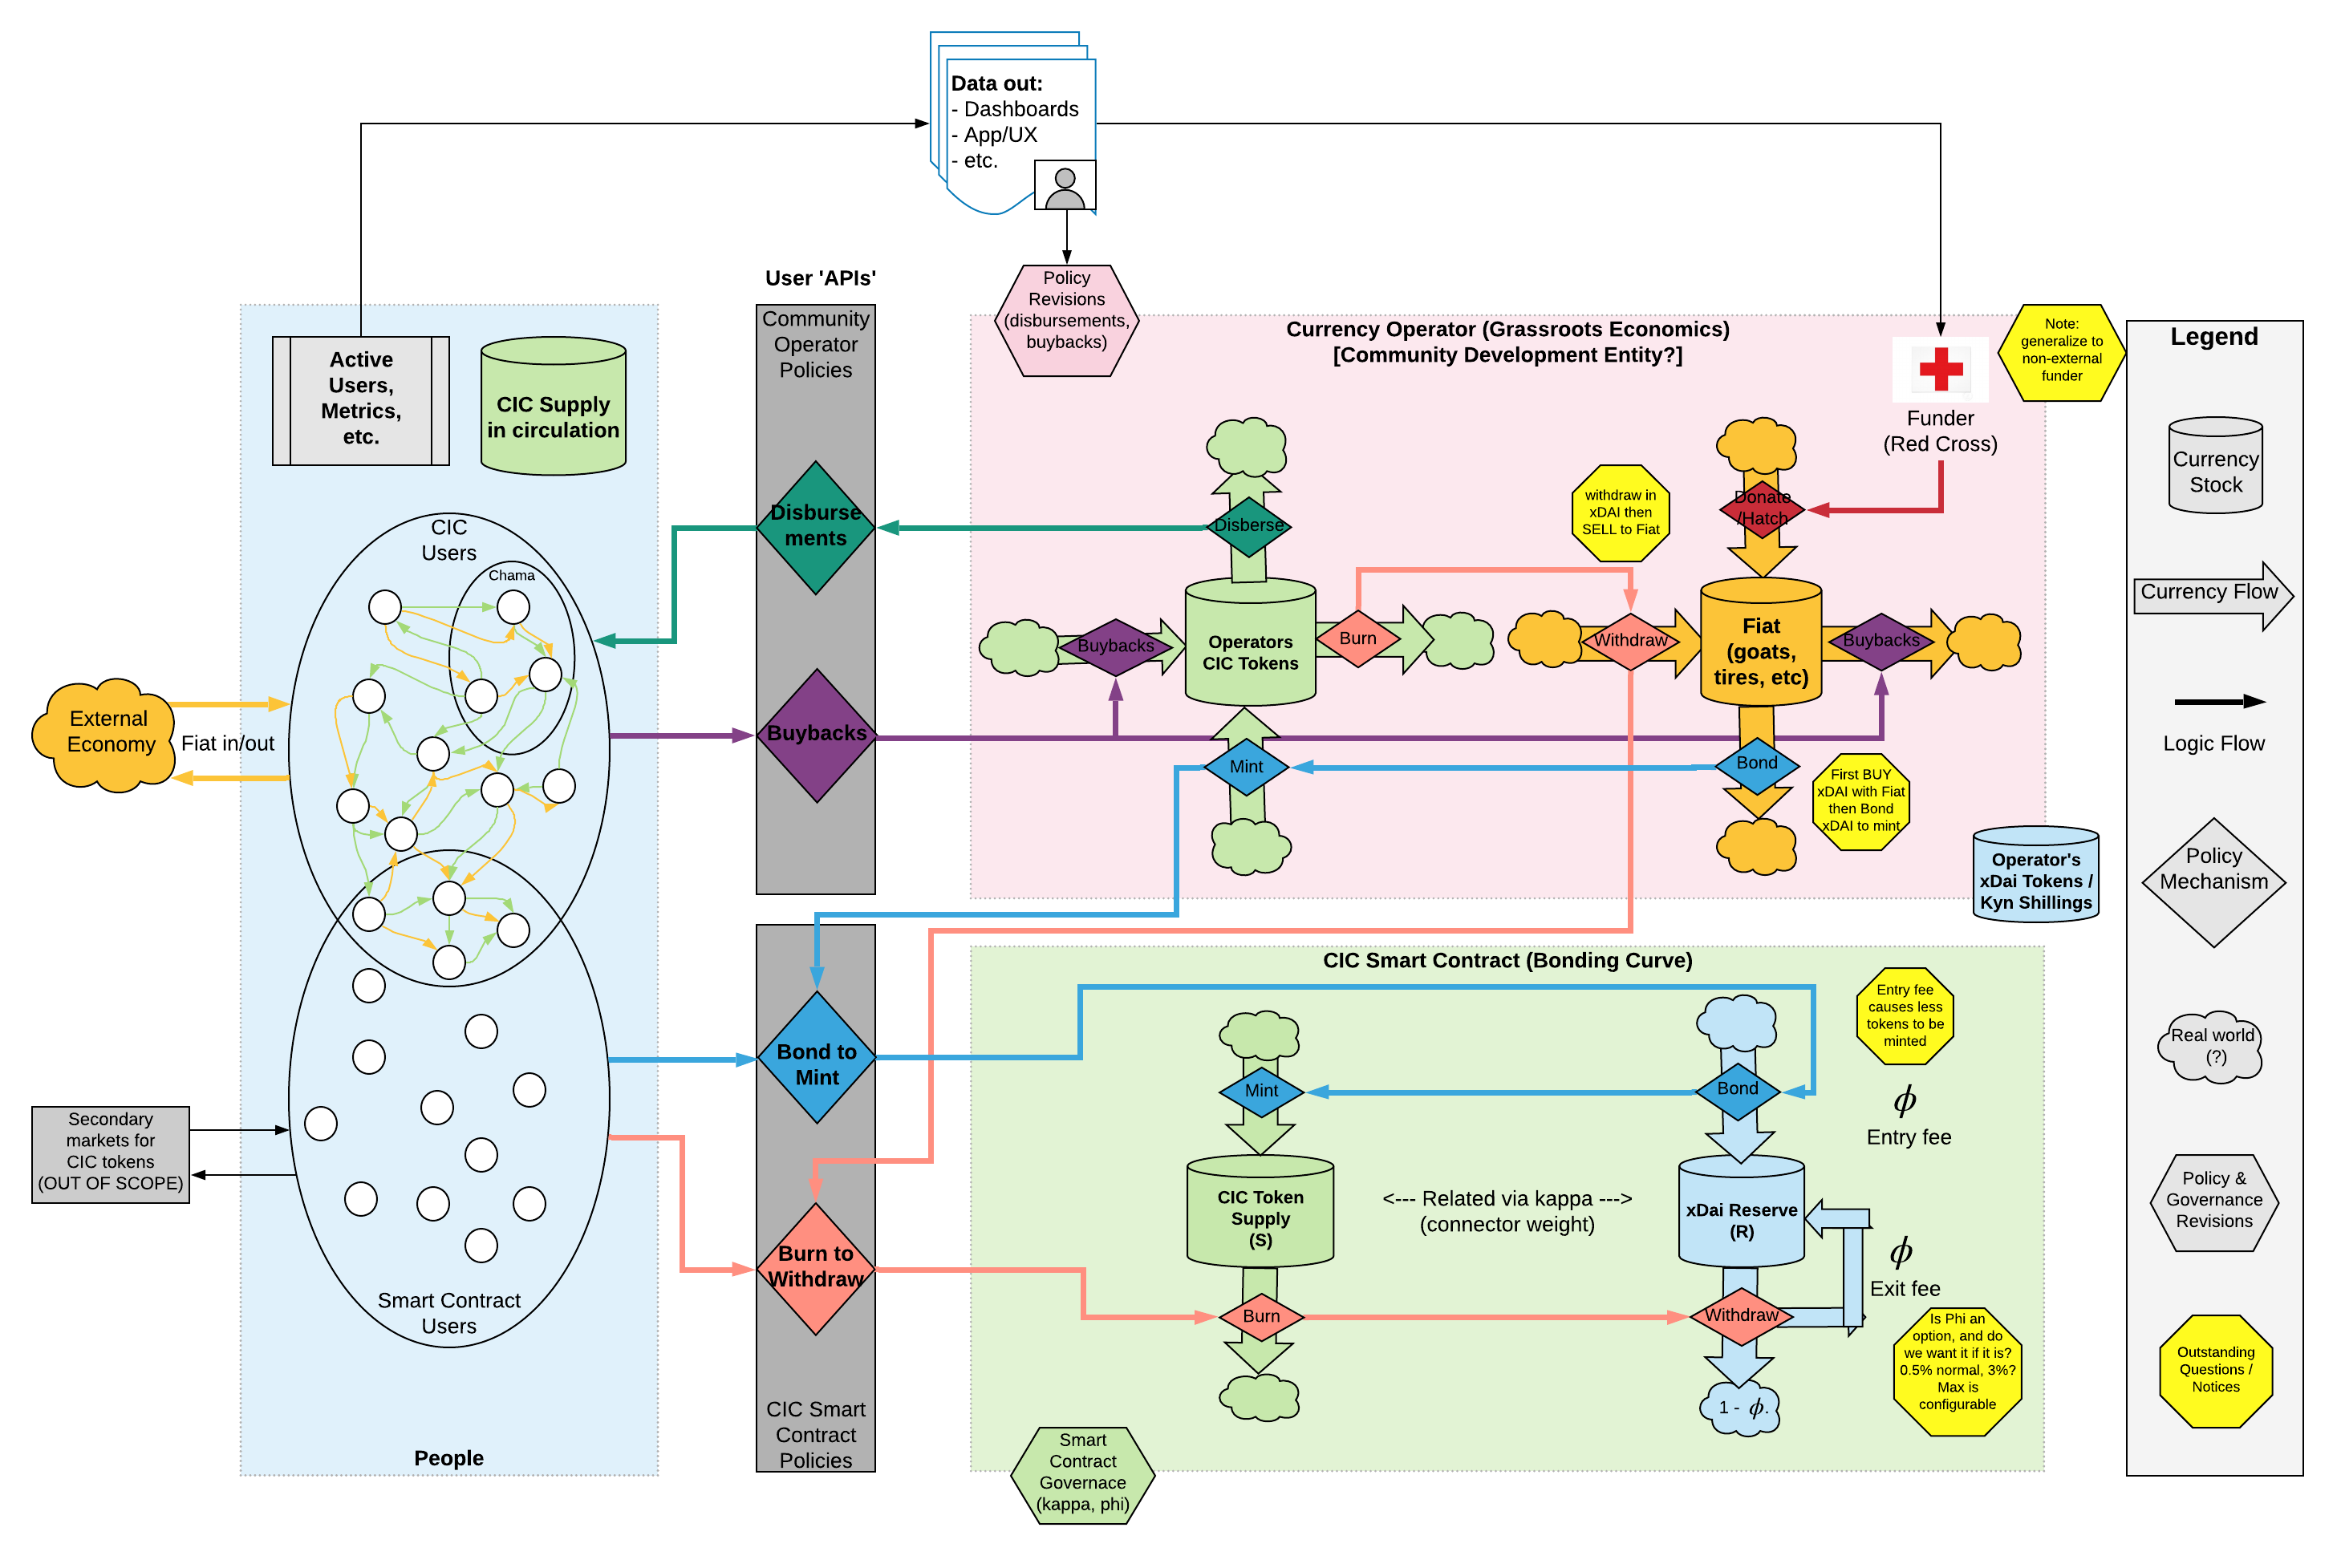

In [2]:
from IPython.display import display, Image
display(Image(filename='images/dualoperator.png'))

## Assumptions

### Modeling Approach - Subpopulation 

To create a representative model of the agent interactions, we will use subpopulation modeling. We take all of the agents and cluster them based off of the following features from full population actual transactional data from Jan - May 11 2020 xDai data (s means source, t means target):
* s_location - source individual location
* s_business_type - source individual business type
* t_location - target individual location
* t_business_type - target individual business type.
* weight, which is tokens, exchange amount
* s_bal - source individual CIC wallet balance
* t_bal - target individual CIC wallet balance

Essentially, we are taking a graph zoom operation, bundling nodes together based off of their likeness. Nodes are constant with edges being transative. The algorithm we use for this graph zoom operation is Kmeans clustering. Based off our descriptive statistical analysis and use of th Gap Statistic created by Stanford researchers Tibshirani, Walther and Hastie in their 2001 [paper](https://web.stanford.edu/~hastie/Papers/gap.pdf), we determined 50 clusters are representative of the subpopulations. All of the flows inside of the bundle become part of the self-loop flow. For example, within cluster 1, agent a can transaction with as b. This will not be reflected within our model as this is intra not inter cluster interactions.

## Gap Statistic of tested clusters

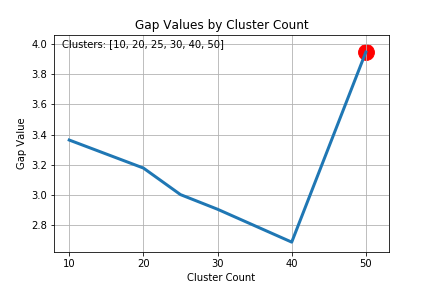

In [2]:
display(Image(filename='images/gap_statistic.png'))

## Plot of 2 Principal Components along with Kmeans clusters

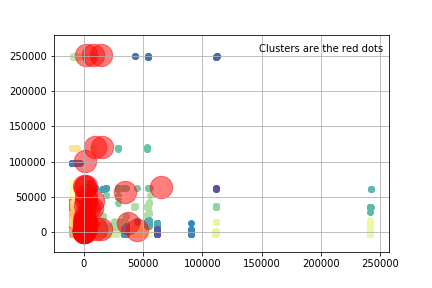

In [3]:
display(Image(filename='images/pca.png'))

## System Initialization
* Agents. Our representation of agents is clusters. We have 50 clusters, from  0 to 49.
* Agent starting native currency is picked from a uniform distribution from the 1st to 3rd quartile of cluster source balances. Starting tokens is the clusters median source balance.
* system = external,cic. We have two system agents, the external economy, as represented in the orange cloud in the graphic above, 
* chama = chama_1,chama_2,chama_3,chama_4

Chamas are currently set to zero, it can be configured for more detailed analysis later on.
* traders = ta,tb,tc

Traders are currently set to zero, it can be configured for more detailed analysis later on.

Utility types ordered and probability are calculated per cluster off of the real transactional data. Below is types and probability for cluster 2:
* Utility Types Ordered
 * Savings Group
 * Farming/Labour
 * Food/Water
* Utility Types Probability 
    * 0.6427282569469506,
    * 0.25045110068567306,
    * 0.1068206423673764},


## What is a Bonding Curve?
Bonding curves are continuous liquidity mechanisms which are used in market design for cryptographically-supported token economies. Bonding curves are an example of an enforceable mechanism through which participating agents influence this state. 

### Basic Definitions
- $R$ = xDai in Reserve
- $S$ = Total Supply of CIC tokens
- $P$ = Spot Price of the Bonding Curve$^*$
- $P \cdot S$ = Market Cap implied by the Spot Price and Token Supply
- $\frac{R}{P \cdot S}$ = Reserve Ratio in the Liquidity Pool$^\dagger$

$^*$ The spot price is the limiting price for both the Bond-to-Mint and the Burn-to-Withdraw Mechanisms in the case with no fees. Realized prices account for slippage and fees, see references.

$^\dagger$ Bonding Curves such as the one being employed by the CIC systems are tools which enforce the Reserve Ratio to be a constant $\rho \in (0,1)$, also called the connector weight. In this work we work with the "curvature" $\kappa = \frac{1}{\rho} = \frac{P \cdot S}{R}$ in order to align notation with associated academic work.


### Conservation Function Enforcing Deposit-to-Mint 
 - Deposit $\Delta R$ xDAI to mint $\Delta S$ CIC tokens
 - Conservation equation: $V(R+ \Delta R', S+\Delta S) = \frac{(S+\Delta S)^\kappa}{R+\Delta R'} =\frac{S^\kappa}{R}$
 - Derived Mint equation: $\Delta S = mint\big(\Delta R ; (R,S)\big)= S\big(\sqrt[\kappa]{(1+\frac{\Delta R}{R})}-1\big)$
 

If the controller wants to burn, the amount decided from the inventory controller, $\Delta S$ is inserted into the following minting equation:
 - Derived Withdraw equation: $\Delta R = withdraw\big(\Delta S ; (R,S)\big)= R\big(1-(1-\frac{\Delta S}{S})^\kappa \big)$
 
### Conservation Function Enforcing Burn-to-Withdraw 
 - Burn $\Delta S$ CIC tokens to withdraw $\Delta R$ xDAI
 - Conservation equation: $V(R- \Delta R', S-\Delta S) = \frac{(S-\Delta S)^\kappa}{R-\Delta R'} =\frac{S^\kappa}{R}$
 - Derived Withdraw equation: $\Delta R = withdraw\big(\Delta S ; (R,S)\big)= R\big(1-(1-\frac{\Delta S}{S})^\kappa \big)$


### Initialization Equations

- Input $R_0$ xDai to generate $S_0$ initial supply
- "Hatch" sale "Price" $p_0$ (xDai per token minted) determines the initial supply: $S_0 = R_0/p_0$
- The 'Connector Weight' in Bancor terms maps to the concept 'Reserve Ratio' $\rho=\frac{1}{\kappa}=\frac{R}{P \cdot S}$
- The initial spot price $P_0$ once the curve is live is $\kappa \frac{R_0}{S_0}$
- Note that $\frac{P_0}{p_0} = \frac{\kappa R_0/S_0}{R_0/S_0}= \kappa$ is leverage applied in deploying the bonding curve.

### Inputs from Stakeholder
- $R_0= 40000$ xDAI
- Conversion rate between USD and Kenyan Shilling is approximately 1:100
- assume $P_0 =  1/100$ in order to ensure spot price is the right order of magnitude.
- leverage rate from past discussions, considering $\kappa =4$
- above implies $S_0 = 4 \times 100 \times 40000 = 160\, Million$ for the initial supply of CIC tokens 


## Initial State Values and Parameters
* Initial operatorFiatBalance = 100,000
* Initial operatorCICBalance = 100,000
* fractionOfDemandInCIC = 0.5
* fractionOfActualSpendInCIC = 0.5 # if an agent is interacting with the external environment, then the actual spend is 100% shilling.


# System step walkthrough

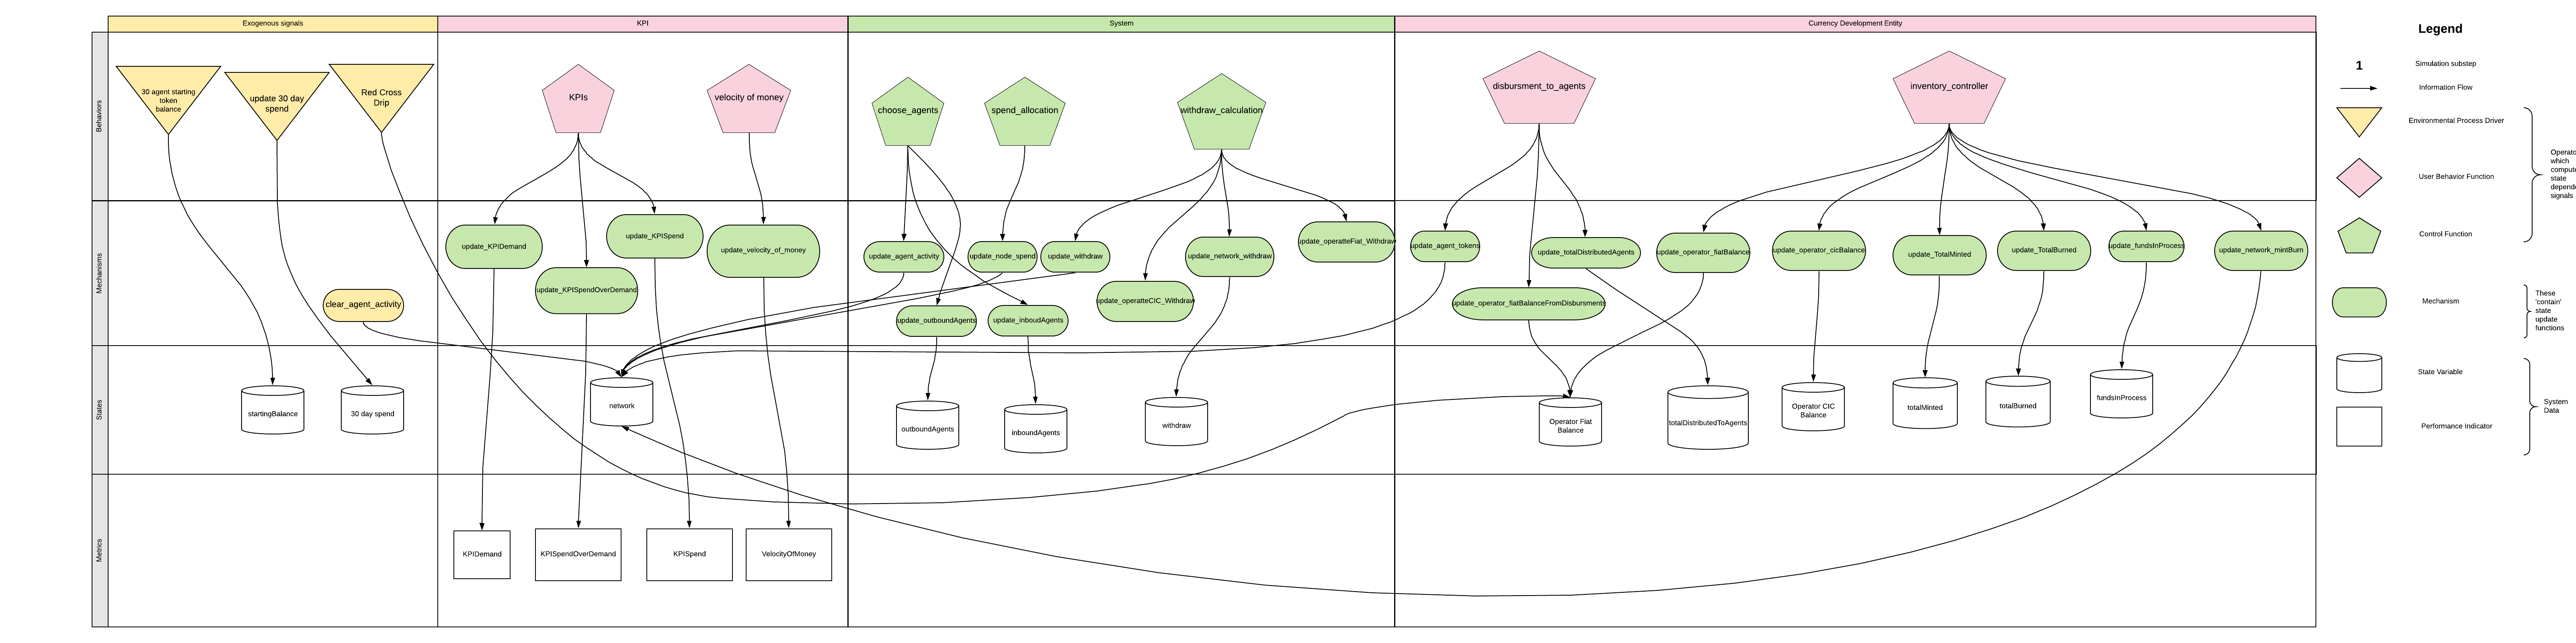

In [4]:
display(Image(filename='images/v4differentialspec.png'))

### Red Cross Drip
Every 90 days, the Red Cross drips 10,000 shilling to the grassroots operator fiat balance. 

## Generators
* Agent generation for each time step: Random choice of all agents minus 5 for both paying and receiving.  

* Agent demand each timestep: demand distributions based off of gaussian for each utility type.
 
### Spend Allocation 

#### Parameters:
* Agent to pay: $i$
* Agent to receive: $j$
* Rank Order Demand: $\frac{v_{i,j}}{d_{i,j}}$
* Amount of currency agent $i$ has to spend, $\gamma$
* Amount of cic agent $i$ has to spend, $\gamma_\textrm{cic}$
* Percentage of transaction in cic, $\phi$
* Spend, $\zeta$


if $\frac{v_{i,j}}{d_{i,j}} * 1-\phi > \gamma_{i} \textrm{and} \frac{v_{i,j}}{d_{i,j}} * \phi > \gamma_\textrm{cic} \Rightarrow \zeta = \frac{v_{i,j}}{d_{i,j}}$ 

else $ \Rightarrow \zeta = \gamma$

Allocate utility type by stack ranking in. Allocate remaining fiat and cic until all demand is met or i runs out.

### Withdraw calculation

The user is able to withdraw up to 50% of the their CIC balance if they have spent 50% of their balance within the last 30 days at a conversion ratio of 1:1, meaning that for every one token withdraw, they receive 1 in native currency. We are assuming that agents want what to withdraw as much as they can.
This is one of the most important control points for Grassroots economics. The more people withdraw CIC from the system, the more difficult it is on the system. The more people can withdraw, the better the adoption however. The inverse also holds true: the less individuals can withdraw, the lower the adoption. 30,000 is the max allowable amount to be withdraw per 30 days. 

## Distribution to agents
#### Parameters
* FrequencyOfAllocation = 30 # frequency of allocation of drip to agents
* idealFiat = 100000
* idealCIC = 100000
* varianceCIC = 30000
* varianceFiat = 30000
* unadjustedPerAgent = 1000
* inventory_controller = False

```
# agent:[centrality,allocationValue]
agentAllocation = {'0':[1,1],'1':[1,1],etc}
```

Every 30 days, a total of unadjustedPerAgent * agents will be distributed among the agents. Allocation will occur based off of the the agent allocation dictionary allocation value. We can optimize the allocation overtime and make a state variable for adjustment overtime as a result of centrality. We are currently assuming that all agents have the same centrality and allocation.

Internal velocity is better than external velocity of the system. Point of leverage to make more internal cycles. Can be used for tuning system effiency.

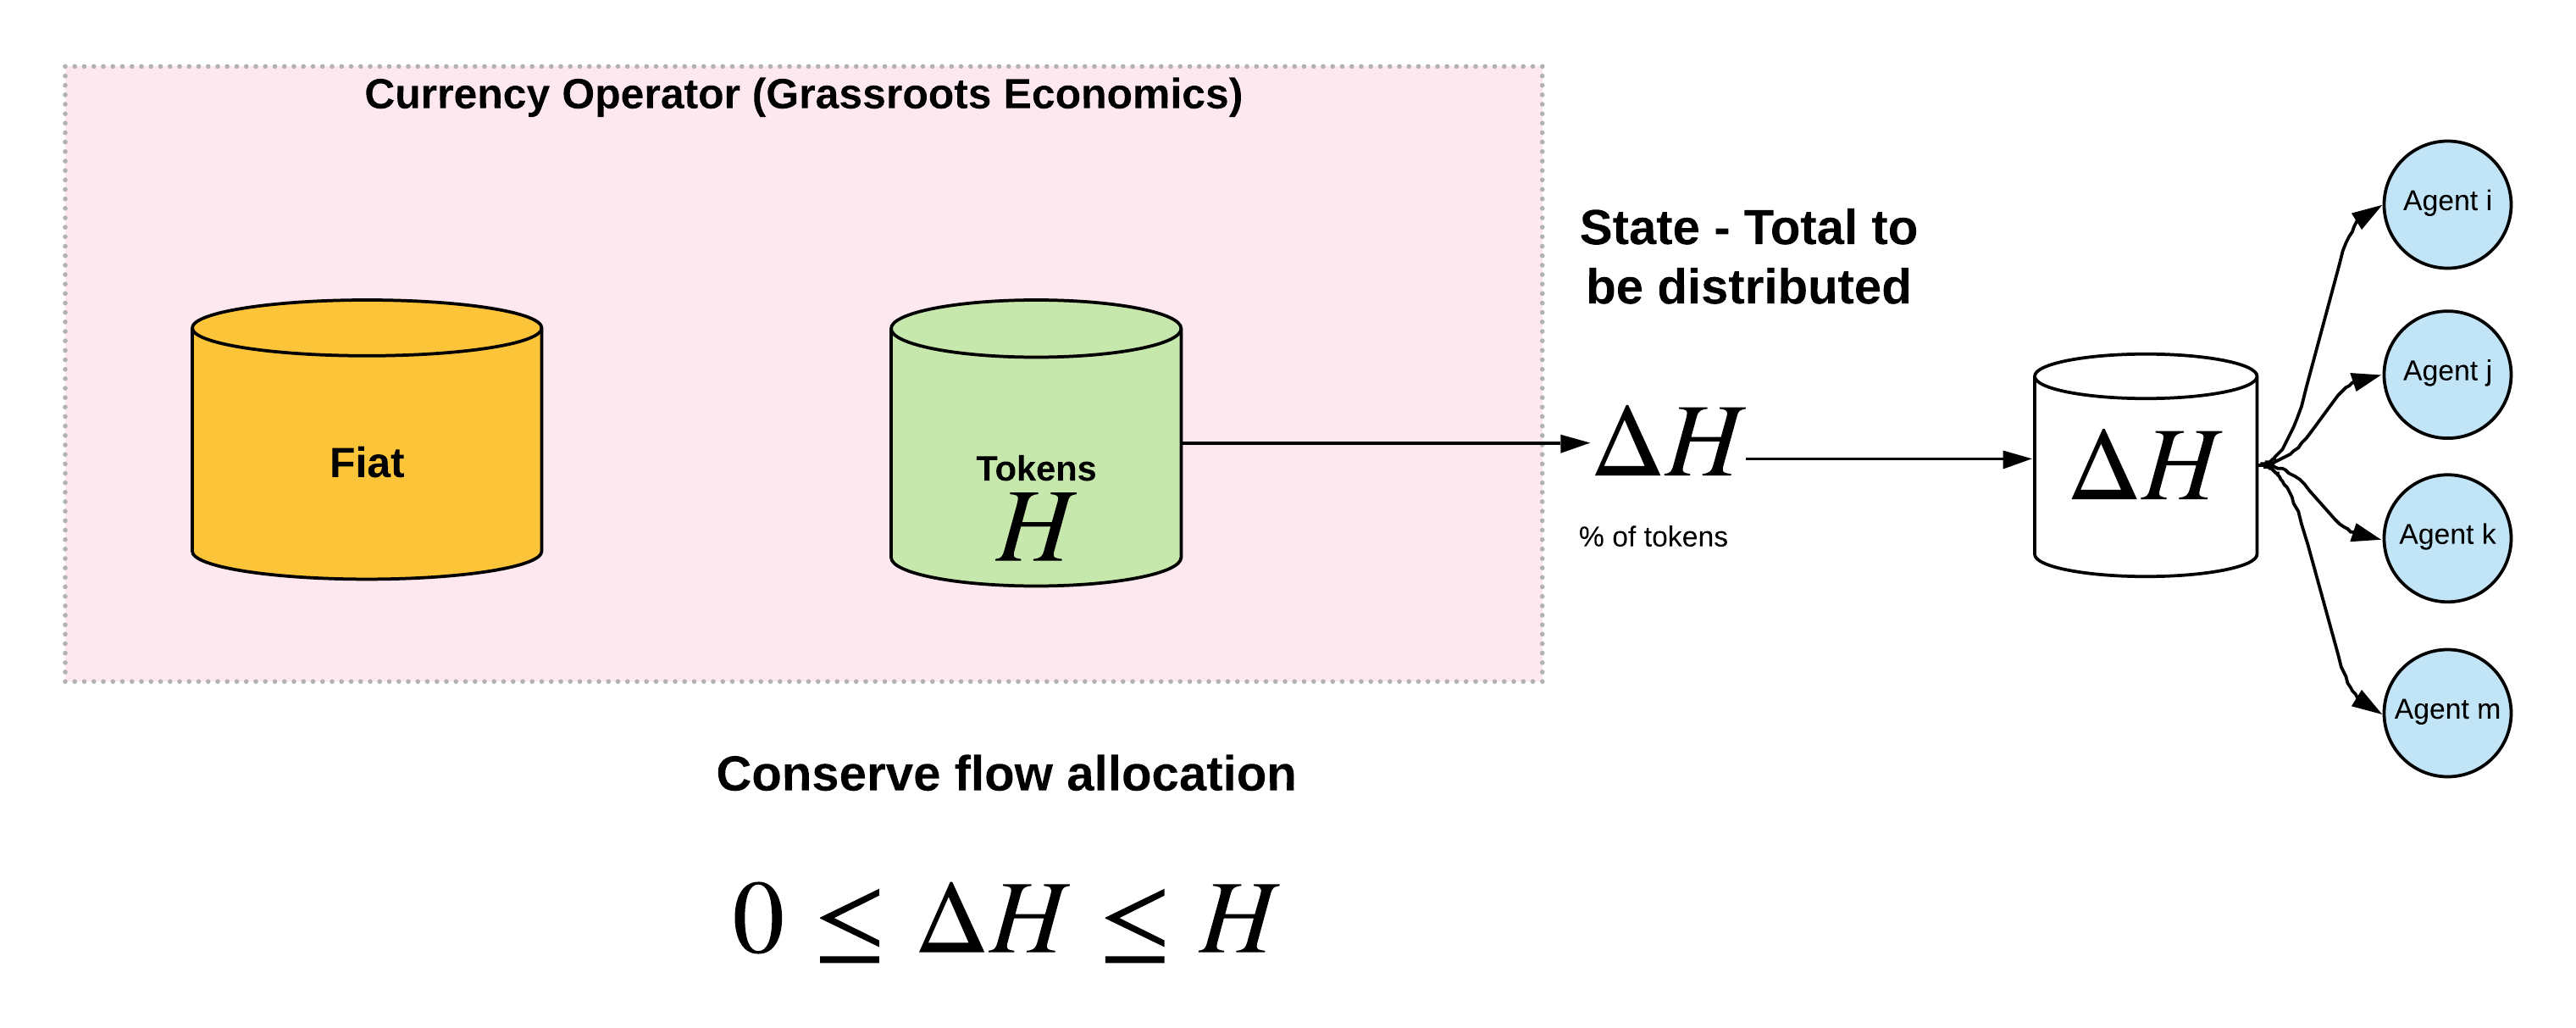

In [5]:
display(Image(filename='images/agentDistribution.png'))

### Inventory Controller
Heuristic Monetary policy hysteresis conservation allocation between fiat and cic reserves. We've created an inventory control function to test if the current balance is in an acceptable tolarance. For the calculation, we use the following 2 variables, current CIC balance and current fiat balance, along with 2 parameters, desired cic and variance. 

We have a parameter called inventory_controller which uses a boolean operator. Currently, the inventory controller is turned off with the value of False.

Below is 
```
if idealFiat - varianceFiat <= actualFiat <= idealFiat + (2*varianceFiat):
        decision = 'none'
        amount = 0
    else:
        if (idealFiat - varianceFiat) > actualFiat:
            decision = 'burn'
            amount = (idealFiat + varianceFiat) - actualFiat
        else:
            pass
        if actualFiat > (idealFiat + varianceFiat):
            decision = 'mint'
            amount = actualFiat - (idealFiat + varianceFiat) 
        else:
            pass

    if decision == 'mint':
        if actualCIC < (idealCIC - varianceCIC):
            if amount > actualCIC:
                decision = 'none'
                amount = 0
            else:
                pass
    if decision == 'none':
        if actualCIC < (idealCIC - varianceCIC):
            decision = 'mint'
            amount = (idealCIC-varianceCIC)
        else:
            pass
   
```

If the controller wants to mint, the amount decided from the inventory controller, $\Delta R$ is inserted into the following minting equation (as described above in the bonding curve section):

- Conservation equation, V0: $V(R+ \Delta R', S+\Delta S) = \frac{(S+\Delta S)^\kappa}{R+\Delta R'} =\frac{S^\kappa}{R}$
- Derived Mint equation: $\Delta S = mint\big(\Delta R ; (R,S)\big)= S\big(\sqrt[\kappa]{(1+\frac{\Delta R}{R})}-1\big)$
 


If the controller wants to burn, the amount decided from the inventory controller, $\Delta S$ is inserted into the following minting equation:
 - Derived Withdraw equation: $\Delta R = withdraw\big(\Delta S ; (R,S)\big)= R\big(1-(1-\frac{\Delta S}{S})^\kappa \big)$
 

There is a built in process lag of 7 days before the newly minted or burned CIC is added to the respective operator accounts.

### Velocity of Money 

Indirect measurement of velocity of money per timestep:

$V_t = \frac{PT}{M}$

Where

* $V_t$ is the velocity of money for all agent transaction in the time period examined
* $P$ is the price level
* $T$ is the aggregated real value of all agent transactions in the time period examined
* $M$ is the average money supply in the economy in the time period examined.



## Simulation run
* 5 monte carlo runs with 100 timesteps. Each timestep is equal to 1 day.


## Proposed Experiments

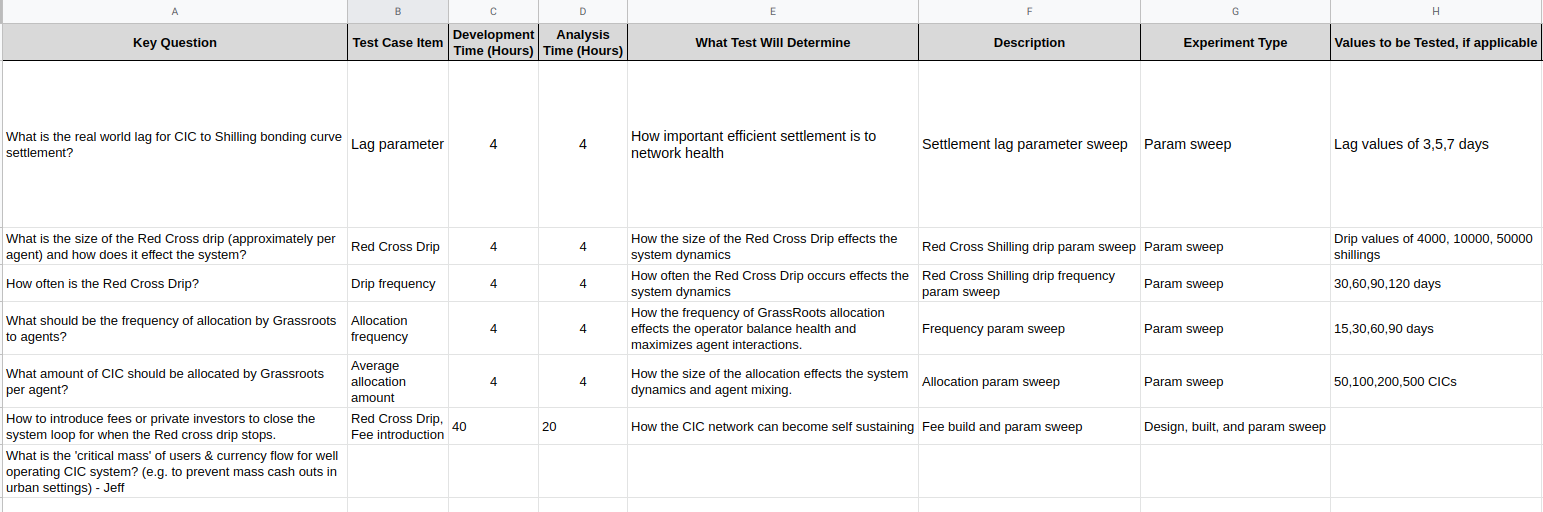

In [3]:
display(Image(filename='images/experiments.png'))

# Run cadCAD model


## Parameter sweep TEMPLATE
We are sweeping the drip frequency of the Red Cross using 30,60, and 90 days.

In cadCAD, we can change the params in the economy config. Below, we are defining 'drip_frequency' in the params.
economyconfig.py
```
params: Dict[str, List[int]] = {
    'drip_frequency': [30,60,90] # in days
}


sim_config = config_sim({
    'N': 5,
    'T': range(100), #day 
    'M': params,
})
```
In the exogenousProcesses.py, we are showing the params being used in the 'division =  timestep % params['drip_frequency']  == 0' system.
exogenousProcesses.py
```
def redCrossDrop(params, step, sL, s, _input):
    '''
    Every 30 days, the red cross drips to the grassroots operator node
    '''
    y = 'operatorFiatBalance'
    fiatBalance = s['operatorFiatBalance']
    
    timestep = s['timestep']
    
    division =  timestep % params['drip_frequency']  == 0

    if division == True:
        fiatBalance = fiatBalance + drip
    else:
        pass

    x = fiatBalance
    return (y, x)
```

/home/aclarkdata/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


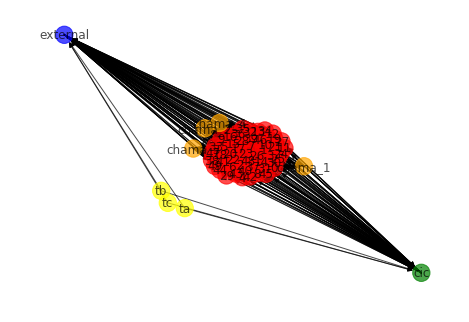

<Figure size 1440x1440 with 0 Axes>

[{'N': 5, 'T': range(0, 100), 'M': {'drip_frequency': 30}}, {'N': 5, 'T': range(0, 100), 'M': {'drip_frequency': 60}}, {'N': 5, 'T': range(0, 100), 'M': {'drip_frequency': 90}}]
[{'N': 5, 'T': range(0, 100), 'M': {'drip_frequency': 30}}, {'N': 5, 'T': range(0, 100), 'M': {'drip_frequency': 60}}, {'N': 5, 'T': range(0, 100), 'M': {'drip_frequency': 90}}]
[{'N': 5, 'T': range(0, 100), 'M': {'drip_frequency': 30}}, {'N': 5, 'T': range(0, 100), 'M': {'drip_frequency': 60}}, {'N': 5, 'T': range(0, 100), 'M': {'drip_frequency': 90}}]


In [1]:
import math
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from model.parts.supportingFunctions import *

pd.options.display.float_format = '{:.2f}'.format

%matplotlib inline
from tabulate import tabulate
from typing import Dict, List

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import clear_output

# The following imports NEED to be in the exact order
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from model import economyconfig
from cadCAD import configs

exec_mode = ExecutionMode()

/home/aclarkdata/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/home/aclarkdata/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/aclarkdata/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


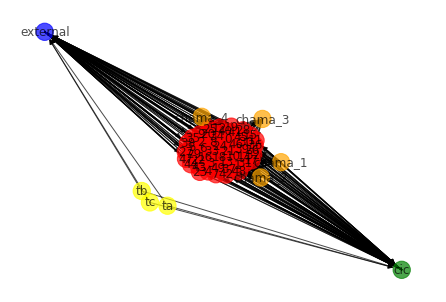

<Figure size 1440x1440 with 0 Axes>

Configurations Length: 15


/home/aclarkdata/anaconda3/lib/python3.7/site-packages/cadCAD/utils/__init__.py:126: FutureWarning: The use of a dictionary to describe Partial State Update Blocks will be deprecated. Use a list instead.
  FutureWarning)


Execution Method: local_simulations
Execution Mode: parallelized


In [ ]:
exec_mode = ExecutionMode()
multi_proc_ctx = ExecutionContext(context=exec_mode.multi_proc)
run = Executor(exec_context=multi_proc_ctx, configs=configs)

i = 0
results = {}
for raw_result, tensor_field in run.execute():
    result = pd.DataFrame(raw_result)
    results[i] = {}
    results[i]['result'] = result
    i += 1

In [20]:
for i in range(0,len(results)):
    results[i]['result']['agents'] = results[i]['result'].network.apply(lambda g: np.array([get_nodes_by_type(g,'Agent')][0]))
    results[i]['result']['agent_tokens'] = results[i]['result'].network.apply(lambda g: np.array([g.nodes[j]['tokens'] for j in get_nodes_by_type(g,'Agent')]))
    results[i]['result']['agent_native_currency'] = results[i]['result'].network.apply(lambda g: np.array([g.nodes[j]['native_currency'] for j in get_nodes_by_type(g,'Agent')]))
    # Create dataframe variables   
    tokens = []
    for j in results[i]['result'].index:
         tokens.append(sum(results[i]['result']['agent_tokens'][j]))

    results[i]['result']['AggregatedAgentCICHolding'] = tokens  
    
    withdraw = []
    for j in results[i]['result'].index:
        try:
             withdraw.append(sum(results[i]['result']['withdraw'][j]))
        except:
            withdraw.append(results[i]['result']['withdraw'][j])

    results[i]['result']['AggregatedWithdraw'] = withdraw 

    currency = []
    for j in results[i]['result'].index:
         currency.append(sum(results[i]['result']['agent_native_currency'][j]))

    results[i]['result']['AggregatedAgentCurrencyHolding'] = currency  

    AggregatedSpend = []
    for j in results[i]['result'].index:
         AggregatedSpend.append(sum(results[i]['result']['KPISpend'][j].values()))

    results[i]['result']['AggregatedAgentSpend'] = AggregatedSpend   

    AggregatedDemand = []
    for j in results[i]['result'].index:
         AggregatedDemand.append(sum(results[i]['result']['KPIDemand'][j].values()))

    results[i]['result']['AggregatedAgentDemand'] = AggregatedDemand  


    AggregatedKPISpendOverDemand = []
    for j in results[i]['result'].index:
         AggregatedKPISpendOverDemand.append(sum(results[i]['result']['KPISpendOverDemand'][j].values()))

    results[i]['result']['AggregatedKPISpendOverDemand'] = AggregatedKPISpendOverDemand  


    AggregatedGapOfDemandMinusSpend = []
    for j in results[i]['result'].index:
         AggregatedGapOfDemandMinusSpend.append(sum(results[i]['result']['KPIDemand'][j].values())- sum(results[i]['result']['KPISpend'][j].values()))

    results[i]['result']['AggregatedGapOfDemandMinusSpend'] = AggregatedGapOfDemandMinusSpend  

In [21]:
params = [30,60,90]
swept = 'Red Cross Drip Frequency'
mean_df,median_df = param_dfs(results,params,swept)
median_df.head()

,timestep,VelocityOfMoney,operatorFiatBalance,operatorCICBalance,totalDistributedToAgents,totalMinted,totalBurned,run,substep,AggregatedAgentCICHolding,AggregatedAgentCurrencyHolding,AggregatedAgentSpend,AggregatedAgentDemand,AggregatedKPISpendOverDemand,AggregatedGapOfDemandMinusSpend,Red Cross Drip Frequency
0,1,2.93,110000.00,100000.00,0,0,0,3,8,255893.50,1802101.00,60368.18,131856.10,9.03,71487.92,30
1,2,2.77,110000.00,100000.00,0,0,0,3,8,255191.18,1801398.68,57138.42,249743.59,9.36,189703.29,30
2,3,1.42,110000.00,100000.00,0,0,0,3,8,254621.90,1800829.40,29204.46,81699.55,9.52,44364.79,30
3,4,2.76,110000.00,100000.00,0,0,0,3,8,251673.54,1797881.04,56556.03,190435.86,14.58,152997.64,30
4,5,1.38,110000.00,100000.00,0,0,0,3,8,254725.58,1800933.07,28295.03,119412.11,5.05,91117.08,30


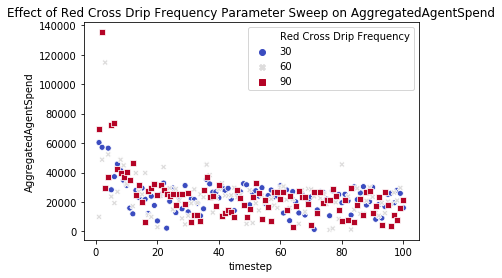

In [22]:
# plot of agent activity per timestep
param_plot(median_df,'timestep', 'AggregatedAgentSpend',swept)

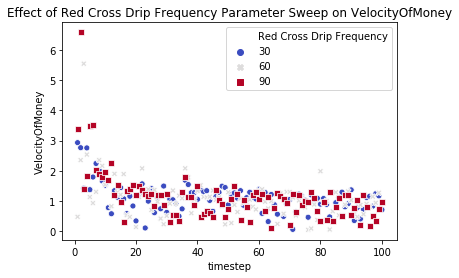

In [24]:
param_plot(median_df,'timestep', 'VelocityOfMoney',swept)

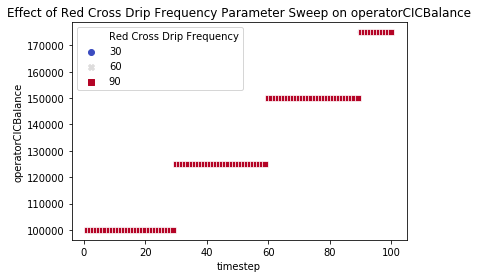

In [25]:
param_plot(median_df,'timestep', 'operatorCICBalance',swept)

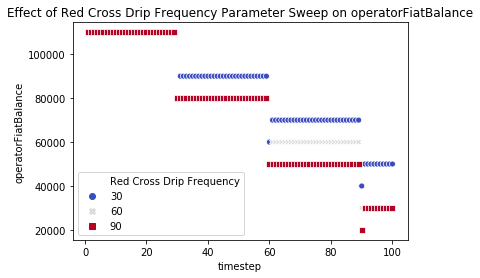

In [26]:
param_plot(median_df,'timestep', 'operatorFiatBalance',swept)

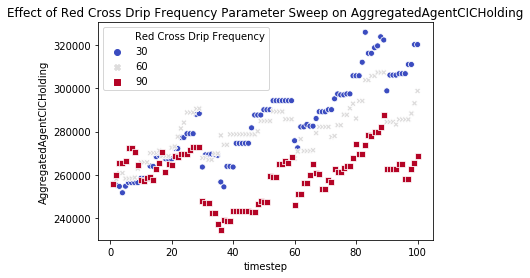

In [27]:
param_plot(median_df,'timestep', 'AggregatedAgentCICHolding',swept)

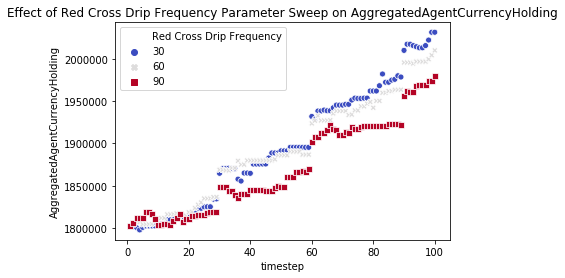

In [28]:
param_plot(median_df,'timestep', 'AggregatedAgentCurrencyHolding',swept)

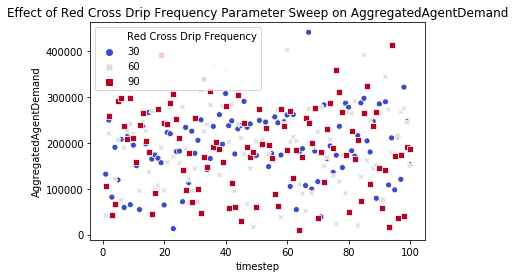

In [29]:
param_plot(median_df,'timestep', 'AggregatedAgentDemand',swept)

In [1]:
#param_plot(median_df,'timestep', 'AggregatedWithdraw',swept)